In [ ]:
import fitz  # PyMuPDF
import numpy as np
import cv2
import matplotlib.pyplot as plt

def pdf_to_image(pdf_path, dpi=300):
    doc = fitz.open(pdf_path)
    images = []
    for page_num in range(len(doc)):
        page = doc[page_num]
        pix = page.get_pixmap(matrix=fitz.Matrix(dpi/72, dpi/72))
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, 3)
        images.append(img)
    return images

# โหลด PDF
pdf_path = "data/Revised Anes Record Form.pdf"
images = pdf_to_image(pdf_path)

# แสดงภาพหน้าแรก
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.show()


FileNotFoundError: no such file: 'mnt/data/Revised Anes Record Form.pdf'

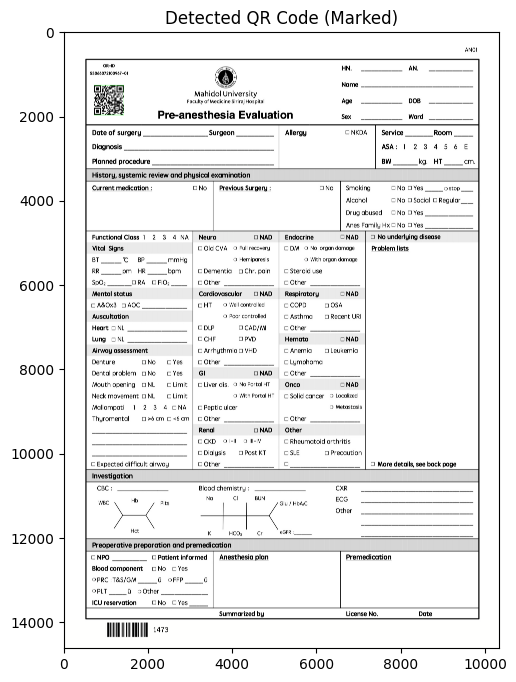

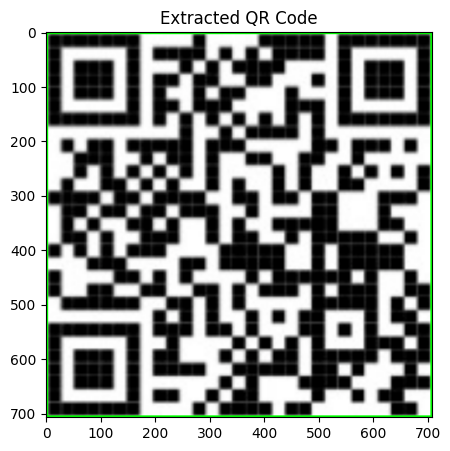

'https://me-qr.com/voHoMww2'

In [ ]:
import cv2
import matplotlib.pyplot as plt
import json
from pyzbar.pyzbar import decode
import numpy as np

def read_qr_code(image):
    image_copy = image.copy()  # Make a writable copy of the image
    decoded_objects = decode(image_copy)
    
    if decoded_objects:
        for obj in decoded_objects:
            points = obj.polygon
            if len(points) > 4:  # If the points form a polygon
                hull = cv2.convexHull(np.array([point for point in points], dtype=np.float32))
                points = hull.reshape(-1, 2)
            points = np.array(points, dtype=np.int32)
            x_min, y_min = points.min(axis=0)
            x_max, y_max = points.max(axis=0)
            w, h = x_max - x_min, y_max - y_min

            # วาดกรอบรอบ QR Code
            cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (0, 255, 0), 5)

            # แสดงภาพที่มี QR Code ถูกมาร์ค
            plt.figure(figsize=(8, 8))
            plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
            plt.title("Detected QR Code (Marked)")
            plt.show()

            # ตัดภาพเฉพาะ QR Code
            qr_crop = image_copy[y_min:y_min + h, x_min:x_min + w]

            # แสดง QR Code แยกต่างหาก
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(qr_crop, cv2.COLOR_BGR2RGB))
            plt.title("Extracted QR Code")
            plt.show()

            return obj.data.decode('utf-8'), points

    return None, None

qr_data, qr_points = read_qr_code(images[0])
qr_data

# แสดงข้อมูลจาก qrcode
if qr_data:
    try:
        data = json.loads(qr_data)
    except json.JSONDecodeError:
        data = qr_data  # If qr_data is not JSON, just return the raw data
else:
    data = "No QR code data found"
data

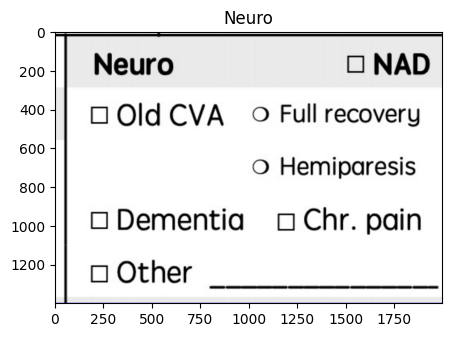

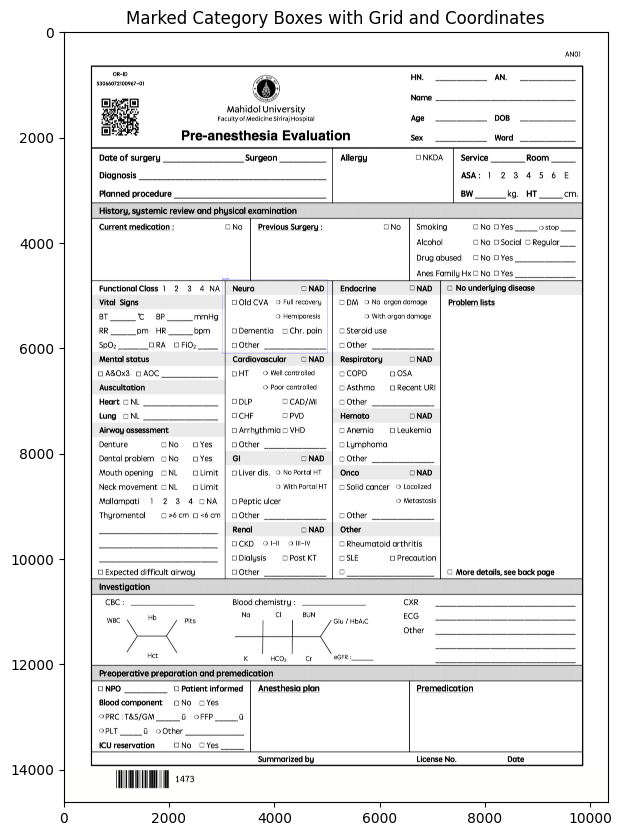

In [ ]:
def mark_category_boxes(image, qr_points, category_boxes):
    image_copy = image.copy()
    qr_center = np.mean(qr_points, axis=0).astype(int)
    
    for category, box in category_boxes.items():
        x_min, y_min, x_max, y_max = box
        box_center = np.array([(x_min + x_max) // 2, (y_min + y_max) // 2])
        distance = np.linalg.norm(qr_center - box_center)
        
        # วาดกรอบรอบกล่องหมวดหมู่
        cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image_copy, f"{category} ({distance:.2f})", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        
        # แสดงภาพแยกตามหมวดหมู่
        cropped_box = image_copy[y_min:y_max, x_min:x_max]
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(cropped_box, cv2.COLOR_BGR2RGB))
        plt.title(f"{category}")
        plt.show()
    
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title("Marked Category Boxes with Grid and Coordinates")
    plt.show()

# Example usage
category_boxes = {
    "Neuro": [3000, 4700, 5000, 6100],
}

# Assuming qr_points is already defined
mark_category_boxes(images[0], qr_points, category_boxes)